In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import itertools
from sklearn.metrics import r2_score
import scipy

In [4]:
seed = 77
np.random.seed(seed)
torch.manual_seed(8)

start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 2

In [6]:
df_etc = pd.read_csv('../etc.csv', index_col = 0)
def get_canocal(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True)
df_etc['measured log solubility in mols per litre'] = df_etc.Exp_LogS


/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


number of all smiles:  1248
number of successfully processed smiles:  1248


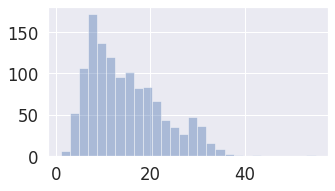

In [7]:
task_name = 'solubility'
tasks = ['measured log solubility in mols per litre']

raw_filename = "./delaney-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smiles_tasks_df = smiles_tasks_df.append(df_etc)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [8]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print("not processed items")
uncovered_df

not processed items


,Compound ID,ESOL predicted log solubility in mols per litre,Exp_LogS,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,cano_smiles
934,Methane,-0.636,NaN,0.0,16.043,0.0,0.0,0.0,0.0,-0.9,C,C


In [9]:
#remained_df
tdf = remained_df.iloc[-120:]
remained_df = remained_df.iloc[:-120, ]
tdf

,Compound ID,ESOL predicted log solubility in mols per litre,Exp_LogS,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,cano_smiles
ETC-2074803,NaN,NaN,-5.792884,NaN,NaN,NaN,NaN,NaN,NaN,-5.792884,c1ccc(cc1)n1cnc2c1cc(cc2)c1ccnc2c1cc[nH]2,c1ccc(-n2cnc3ccc(-c4ccnc5[nH]ccc45)cc32)cc1
ETC-2074535,NaN,NaN,-5.649890,NaN,NaN,NaN,NaN,NaN,NaN,-5.649890,NCc1cccc(c1)n1cnc2c1cc(cc2)c1ccnc2c1cc[nH]2,NCc1cccc(-n2cnc3ccc(-c4ccnc5[nH]ccc45)cc32)c1
ETC-2075031,NaN,NaN,-5.709442,NaN,NaN,NaN,NaN,NaN,NaN,-5.709442,CC(c1cccc(c1)n1cnc2c1cc(cc2)c1ccnc2c1cc[nH]2)N,CC(N)c1cccc(-n2cnc3ccc(-c4ccnc5[nH]ccc45)cc32)c1
ETC-2075002,NaN,NaN,-6.101133,NaN,NaN,NaN,NaN,NaN,NaN,-6.101133,NCc1cc(C)cc(c1)n1cnc2c1cc(cc2)c1ccnc2c1cc[nH]2,Cc1cc(CN)cc(-n2cnc3ccc(-c4ccnc5[nH]ccc45)cc32)c1
ETC-2075255,NaN,NaN,-5.588454,NaN,NaN,NaN,NaN,NaN,NaN,-5.588454,NCc1cc(C#N)cc(c1)n1cnc2c1cc(cc2)c1ccnc2c1cc[nH]2,N#Cc1cc(CN)cc(-n2cnc3ccc(-c4ccnc5[nH]ccc45)cc3...
...,...,...,...,...,...,...,...,...,...,...,...,...
ETC-2081960,NaN,NaN,-5.428636,NaN,NaN,NaN,NaN,NaN,NaN,-5.428636,FCC1NCc2c(C1)cc(c(c2)c1cnn2c1cc(cc2)c1ccnc(c1)...,COc1cc2c(cc1-c1cnn3ccc(-c4ccnc(C)c4)cc13)CNC(C...
ETC-2082012,NaN,NaN,-2.832093,NaN,NaN,NaN,NaN,NaN,NaN,-2.832093,Nc1nccc(c1)c1ccn2c(c1)c(cn2)c1nn(cc1C)C1CNC1,Cc1cn(C2CNC2)nc1-c1cnn2ccc(-c3ccnc(N)c3)cc12
ETC-2082096,NaN,NaN,-5.232025,NaN,NaN,NaN,NaN,NaN,NaN,-5.232025,COc1ccc(cc1c1cnn2c1cc(cc2)c1ccnc2c1cc[nH]2)CN1...,COc1ccc(CN2CCC2)cc1-c1cnn2ccc(-c3ccnc4[nH]ccc3...
ETC-2082097,NaN,NaN,-5.327038,NaN,NaN,NaN,NaN,NaN,NaN,-5.327038,COc1ccc(cc1c1cnn2c1cc(cc2)c1ccnc(c1)N)CN1CC(C1)F,COc1ccc(CN2CC(F)C2)cc1-c1cnn2ccc(-c3ccnc(N)c3)...


In [10]:
remained_df = remained_df.reset_index(drop=True)
test_df = remained_df.sample(frac=1/10, random_state=108) # test set # the original seed

training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=108) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(len(test_df),sorted(test_df.cano_smiles.values))


In [11]:
from joblib import dump
dump((train_df, valid_df,test_df), './ESOL_train_valid_test.data')

['./ESOL_train_valid_test.data']

In [12]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [13]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()


In [14]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["valid_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':valid_MAE, 'test_MAE':valid_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':valid_MAE, 'test_MSE':valid_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if valid_MSE < best_param["valid_MSE"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE"] = valid_MSE
        if valid_MSE < 0.35:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >8) and (epoch - best_param["valid_epoch"] >10):        
        break
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    
    train(model, train_df, optimizer, loss_function)


0 3.7737136 3.8991864
1 2.6082633 2.6569974
2 1.8281046 1.8177178
3 1.7419927 1.7096614
4 1.7181038 1.7052078
5 1.6123391 1.6298193
6 1.508896 1.5132359
7 1.3532649 1.3761426
8 1.1364074 1.1045923
9 1.0510132 1.0763365
10 0.98457783 1.0262574
11 0.90090495 0.9035735
12 0.8857861 0.8736999
13 0.82235193 0.79522324
14 0.8662059 0.79618984
15 0.8087496 0.7888893
16 0.72026974 0.7430566
17 0.7419629 0.8120538
18 0.6983091 0.75228536
19 0.6895053 0.76706237
20 0.6619279 0.7441975
21 0.64224476 0.69393337
22 0.6300534 0.6743145
23 0.6353157 0.6657666
24 0.6116496 0.6655681
25 0.63720864 0.6829807
26 0.58507216 0.67095625
27 0.6264802 0.6760677
28 0.5980941 0.6612622
29 0.5890588 0.6483975
30 0.5793454 0.64393616
31 0.5825914 0.7080818
32 0.5933717 0.7164132
33 0.55189985 0.6661504
34 0.5523319 0.6617177
35 0.60838395 0.74283224
36 0.5629783 0.67745876
37 0.56499046 0.6726356
38 0.52877545 0.62648684
39 0.5525897 0.6888959
40 0.51168567 0.6358978
41 0.5202169 0.6514712
42 0.5302394 0.6779616


/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Fingerprint. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GRUCe

51 0.49386653 0.5848357
52 0.4707626 0.5951008
53 0.46649387 0.6120167
54 0.48582268 0.613688
55 0.5006118 0.61744
56 0.45424616 0.62942976
57 0.44938868 0.62617105
58 0.45902687 0.62214196
59 0.46865273 0.6295949
60 0.4553449 0.63036925
61 0.4348106 0.60880405
62 0.44210535 0.6249625
63 0.42935708 0.6024498
64 0.45199117 0.5878162
65 0.5264818 0.6387515
66 0.5364989 0.6219217
67 0.55729026 0.6466282
68 0.45589605 0.5932851
69 0.43433797 0.5699647
70 0.4286546 0.5741767
71 0.45387983 0.5882474
72 0.45173994 0.59406894
73 0.41026518 0.5840387
74 0.39639705 0.58014435
75 0.39818168 0.57699454
76 0.39905894 0.59644175
77 0.39262465 0.59530807
78 0.39130464 0.56734073
79 0.3884394 0.5529745
80 0.3778096 0.57649267
81 0.39685345 0.6014925
82 0.40617377 0.60774726
83 0.36736587 0.59536666
84 0.4119492 0.61937416
85 0.38407847 0.60473156
86 0.38288236 0.5993305
87 0.36718503 0.5890395
88 0.36858946 0.59800607
89 0.3707081 0.61474985
90 0.384117 0.6232688
91 0.38111758 0.63485175
92 0.39913693

In [15]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["valid_epoch"],"\n","test RMSE:",np.sqrt(test_MSE))

best epoch: 79 
 test RMSE: 0.48232767


In [18]:
def eval2(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    pred = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.iloc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
        pred.extend(mol_prediction.data.squeeze().cpu().numpy())
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(test_MAE_list).mean(), np.sqrt(np.array(test_MSE_list).mean()),pred

In [19]:
eval2(model, tdf)[0:2] # MAE, RMSE

(1.48772, 1.6693403)

In [20]:
df_etc['attentiveFP_%s' % seed] = eval2(model, tdf)[-1]

In [21]:
df_etc.corr()

,Exp_LogS,measured log solubility in mols per litre,attentiveFP_77
Exp_LogS,1.000000,1.000000,0.390625
measured log solubility in mols per litre,1.000000,1.000000,0.390625
attentiveFP_77,0.390625,0.390625,1.000000


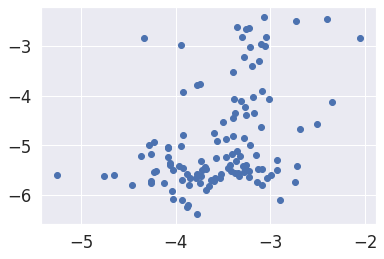

In [23]:
plt.scatter(df_etc.attentiveFP_77, df_etc.Exp_LogS)